# Credit Card Fraud Detection with XGBoost (Imbalanced Learning Pipeline)

This notebook builds an end-to-end **credit card fraud detection** baseline using the classic *highly imbalanced* transaction dataset (features `Time`, `Amount`, and PCA-transformed components `V1`–`V28`, with target label `Class`). The focus is on demonstrating a **clean, leakage-safe training workflow** for imbalanced classification and exporting a production-ready artifact.

# Imports

### Uses:
- **Data/Plotting:** `pandas`, `numpy`, `matplotlib`, `seaborn`
- **Modeling:** `scikit-learn`, `imbalanced-learn`, `xgboost`
- **Persistence:** `joblib`

### Key modeling utilities include:
- `train_test_split` with stratification
- `RobustScaler` for outlier-resistant scaling
- `SMOTE` for oversampling minority (fraud) class
- `XGBClassifier` for gradient-boosted decision trees

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Scikit-Learn Ecosystem
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    average_precision_score, 
    precision_recall_curve
)

# Imbalanced Learning & Modeling
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# Load Data

Loads a CSV dataset (as configured, from a Kaggle input path) and prints:
- dataset shape
- normalized class distribution (to highlight imbalance)

In [2]:
df = pd.read_csv('/kaggle/input/datasets/organizations/mlg-ulb/creditcardfraud/creditcard.csv')

print(f"Dataset Shape: {df.shape}")
print("Class Distribution:")
print(df['Class'].value_counts(normalize=True))

Dataset Shape: (284807, 31)
Class Distribution:
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


# Exploratory Data Analysis (EDA)

Creates a compact EDA panel to validate basic assumptions and inspect imbalance:
- **Class distribution** (fraud vs non-fraud countplot)
- **Transaction `Amount` distribution** (histogram with **log-scaled** y-axis)
- **Transaction `Time` distribution** (histogram)

This step is intended to quickly confirm:
- extreme label imbalance
- heavy-tailed transaction amounts
- temporal spread of transactions

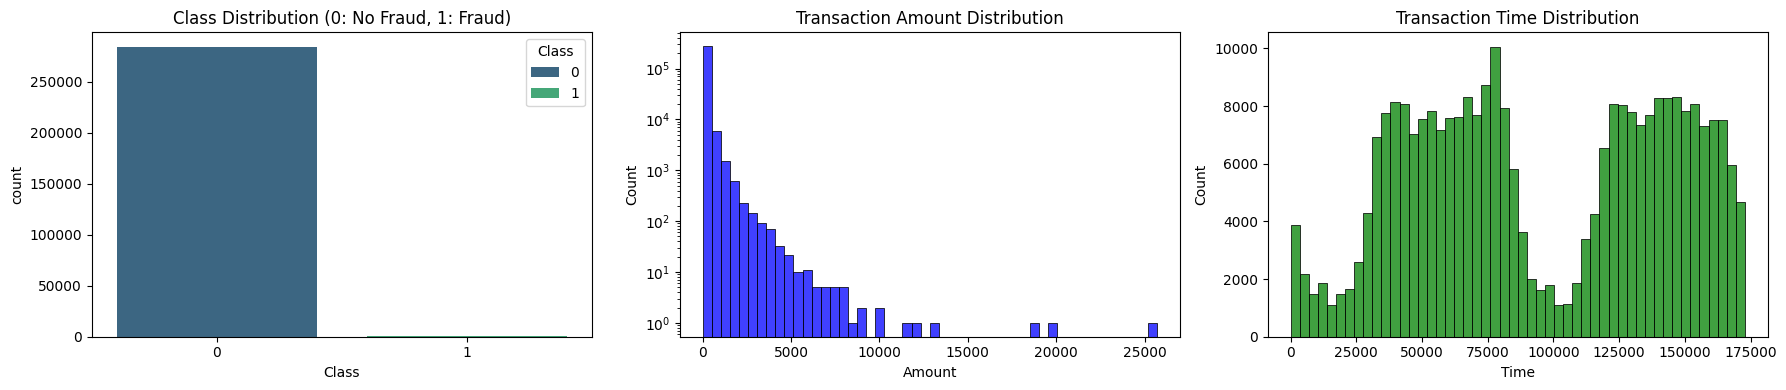

In [3]:
# Visualizing the imbalance and feature distributions
fig, ax = plt.subplots(1, 3, figsize=(18, 4))

# Class Distribution
sns.countplot(x='Class', data=df, ax=ax[0], hue='Class', palette='viridis')
ax[0].set_title('Class Distribution (0: No Fraud, 1: Fraud)')

# Amount Distribution (Log scale for better visualization)
sns.histplot(df['Amount'], bins=50, ax=ax[1], color='blue')
ax[1].set_title('Transaction Amount Distribution')
ax[1].set_yscale('log')

# Time Distribution
sns.histplot(df['Time'], bins=50, ax=ax[2], color='green')
ax[2].set_title('Transaction Time Distribution')

plt.tight_layout()
plt.show()

# Preprocessing

Defines:
- `X` = all features except `Class`
- `y` = `Class`

Performs a **stratified** train/test split to preserve fraud ratio in both sets:
- `test_size = 0.2`
- `random_state = 42`
- `stratify = y`

**Important design choice:**  
No oversampling is applied before the split. Oversampling is handled **inside the pipeline** to prevent data leakage into evaluation data.

In [4]:
# We scale 'Time' and 'Amount'. V1-V28 are already PCA transformed and scaled.
# We do not apply SMOTE here. We apply it inside the training loop/pipeline
# to strictly prevent data leakage into the validation set.

X = df.drop('Class', axis=1)
y = df['Class']

# Stratified Split: Maintains the ratio of frauds in both train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Building the Pipeline

Builds an `imblearn` pipeline with three stages:

1. **RobustScaler**
   - Used to reduce sensitivity to outliers (especially relevant for `Amount` and `Time`).
   - Note: PCA features `V1`–`V28` are already scaled; re-scaling is kept for simplicity in this proof-of-concept.

2. **SMOTE**
   - `sampling_strategy = 0.2` (minority class increased to ~20% of majority, avoiding overly synthetic class balance)
   - `random_state = 42`

3. **XGBClassifier**
   - Core hyperparameters:
     - `n_estimators = 100`
     - `learning_rate = 0.1`
     - `max_depth = 5`
     - `eval_metric = "logloss"`
     - `n_jobs = -1`
     - `random_state = 42`
   - `scale_pos_weight = 1` since SMOTE is already addressing imbalance in training.

In [5]:
# We need to specify columns to scale. 
# Since Scikit-Learn Pipelines process the whole array, we usually scale everything 
# or use ColumnTransformer. Since V1-V28 are already scaled, re-scaling them 
# with RobustScaler is generally harmless and keeps the pipeline simple for this POC.

pipeline = ImbPipeline([
    ('scaler', RobustScaler()), 
    ('smote', SMOTE(random_state=42, sampling_strategy=0.2)), # 0.2 ratio prevents over-faking
    ('classifier', XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        scale_pos_weight=1, # SMOTE handles the balancing, so we keep this default
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1
    ))
])

# Training

In [6]:
print("\nStarting Training...")
pipeline.fit(X_train, y_train)
print("Training Complete.")


Starting Training...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:54:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training Complete.


# Evaluation

Evaluates on the untouched test set using:
- **Predicted labels** (`predict`)
- **Predicted probabilities** (`predict_proba`)

Reports:
- **AUPRC (Average Precision)** via `average_precision_score`  
  (preferred over ROC-AUC in extreme imbalance scenarios)
- **Classification report** (precision/recall/F1 per class)
- **Confusion matrix heatmap** for error inspection (false positives vs false negatives)


Area Under Precision-Recall Curve (AUPRC): 0.8512

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.51      0.88      0.64        98

    accuracy                           1.00     56962
   macro avg       0.75      0.94      0.82     56962
weighted avg       1.00      1.00      1.00     56962



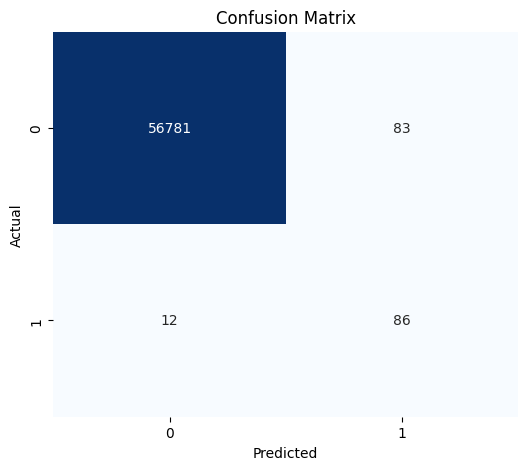

In [7]:
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

# Metrics
auprc = average_precision_score(y_test, y_pred_proba)
print(f"\nArea Under Precision-Recall Curve (AUPRC): {auprc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Export Artifacts

In [8]:
model_filename = 'fraud_detection_pipeline.pkl'
joblib.dump(pipeline, model_filename)
print(f"\nArtifact exported: {model_filename}")

# Verification load
loaded_model = joblib.load(model_filename)
print("Verification: Model loaded successfully.")


Artifact exported: fraud_detection_pipeline.pkl
Verification: Model loaded successfully.
